# Anamoly Detection Example

In [16]:
from datetime import datetime, timedelta

import pandas as pd
import numpy.random as nr
import numpy as np
import random
import string
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
class ClaimsDataGenerator:
    def __init__(self, start_date='2023-01-01', num_months=12):
        self.start_date = datetime.strptime(start_date, '%Y-%m-%d')
        self.num_months = num_months
        
        self.coverage_types = {
            'PI': 'Personal Injury Protection',
            'MP': 'Medical Payments Coverage',
            'AL': 'Automobile Liability',
            'UM': 'Underinsured Motorist'
        }
        
        self.states = {
            'FL': 'Florida', 'NY': 'New York', 'CA': 'California',
            'TX': 'Texas', 'IL': 'Illinois', 'PA': 'Pennsylvania'
        }
        
        # Updated company profiles with baseline minimums
        self.company_profiles = {
            'steady': {
                'min_daily_claims': 5,    # Minimum daily claims
                'base_volume': (20, 5),   # Normal daily variation
                'bulk_chance': 0.1,       # 10% chance of bulk claims
                'bulk_size': (10, 20),    # Size of bulk claims
                'drop_chance': 0.02       # 2% chance of significant drop
            },
            'high_volume': {
                'min_daily_claims': 15,
                'base_volume': (40, 10),
                'bulk_chance': 0.2,
                'bulk_size': (30, 50),
                'drop_chance': 0.05
            },
            'volatile': {
                'min_daily_claims': 10,
                'base_volume': (30, 15),
                'bulk_chance': 0.15,
                'bulk_size': (20, 40),
                'drop_chance': 0.1
            },
            'anomalous': {
                'min_daily_claims': 8,
                'base_volume': (25, 20),
                'bulk_chance': 0.3,
                'bulk_size': (40, 100),
                'drop_chance': 0.15
            }
        }

    def generate_id(self):
        return random.randint(10000, 99999)

    def generate_name(self):
        first_names = ['John', 'Mary', 'James', 'Patricia', 'Robert', 'Linda', 'Michael', 'Barbara']
        last_names = ['Smith', 'Johnson', 'Williams', 'Brown', 'Jones', 'Garcia', 'Miller', 'Davis']
        return random.choice(first_names), random.choice(last_names)

    def generate_daily_claims(self, date, company_id, company_name, profile_info, is_drop_day=False):
        """Generate claims for a single day"""
        claims = []
        profile = self.company_profiles[profile_info]
        
        # Determine number of claims for this day
        if is_drop_day:
            # Significant drop day - generate fewer claims than baseline
            num_claims = random.randint(0, profile['min_daily_claims'] - 1)
        else:
            # Normal day - generate at least minimum claims plus variation
            base_claims = max(profile['min_daily_claims'], 
                            int(nr.normal(*profile['base_volume'])))
            
            # Check for bulk claiming day
            if random.random() < profile['bulk_chance']:
                bulk_size = random.randint(*profile['bulk_size'])
                num_claims = base_claims + bulk_size
            else:
                num_claims = base_claims

        # Generate the claims
        if num_claims > 0:
            coverage_type = random.choice(list(self.coverage_types.keys()))
            state_abbr = random.choice(list(self.states.keys()))
            
            for _ in range(num_claims):
                provider_first_name, provider_last_name = self.generate_name()
                
                claim = {
                    'ODS_CUSTOMER_ID': company_id,
                    'CUSTOMER_NAME': company_name,
                    'DATA_LAST_UPDATED_DATE': date.strftime('%Y-%m-%d'),
                    'COMPANY_ID': company_id,
                    'COMPANY': company_name,
                    'OFFICE_ID': self.generate_id(),
                    'CLAIM_ID_NO': self.generate_id(),
                    'CLAIM_DATE_OF_LOSS': (date - timedelta(days=random.randint(1, 30))).strftime('%Y-%m-%d'),
                    'CLAIM_CREATE_DATE': date.strftime('%Y-%m-%d'),
                    'CLAIM_COVERAGE_TYPE_ABBR': coverage_type,
                    'CLAIM_COVERAGE_TYPE': self.coverage_types[coverage_type],
                    'CONFORMED_STATE_OF_JURISDICTION_ABBR': state_abbr,
                    'CONFORMED_STATE_OF_JURISDICTION': self.states[state_abbr],
                    'BILL_ID': self.generate_id(),
                    'BILL_CREATE_DATE': date.strftime('%Y-%m-%d'),
                    'PROVIDER_CHARGES': round(random.uniform(500, 5000), 2),
                    'PROVIDER_FIRST_NAME': provider_first_name,
                    'PROVIDER_LAST_NAME': provider_last_name,
                    'MONTH': date.month,
                    'YEAR': date.year,
                    'PROFILE_TYPE': profile_info,
                    'IS_DROP_DAY': is_drop_day
                }
                claims.append(claim)
                
        return claims

    def generate_dataset(self, num_companies=50):
        records = []
        
        # Assign company profiles
        company_types = (
            ['steady'] * 60 +       # 60% steady companies
            ['high_volume'] * 20 +  # 20% high volume companies
            ['volatile'] * 15 +     # 15% volatile companies
            ['anomalous'] * 5       # 5% anomalous companies
        )
        
        for company_id in range(1000, 1000 + num_companies):
            profile_type = random.choice(company_types)
            company_name = f"Insurance Co {company_id}"
            
            # Generate data for each day in the period
            current_date = self.start_date
            end_date = self.start_date + timedelta(days=30 * self.num_months)
            
            while current_date < end_date:
                # Determine if this is a drop day
                is_drop_day = random.random() < self.company_profiles[profile_type]['drop_chance']
                
                # Generate claims for this day
                daily_claims = self.generate_daily_claims(
                    current_date, company_id, company_name,
                    profile_type, is_drop_day
                )
                records.extend(daily_claims)
                
                current_date += timedelta(days=1)
        
        return pd.DataFrame(records)

In [4]:
def analyze_claiming_patterns(df):
    """Analyze the claiming patterns to identify anomalies"""
    # Daily claim counts
    daily_claims = df.groupby([
        'COMPANY_ID', 'BILL_CREATE_DATE'
    ]).agg({
        'CLAIM_ID_NO': 'count',
        'PROVIDER_CHARGES': 'sum'
    }).reset_index()
    
    daily_claims.columns = ['COMPANY_ID', 'DATE', 'CLAIM_COUNT', 'TOTAL_CHARGES']
    
    # Calculate baseline metrics for each company
    company_stats = daily_claims.groupby('COMPANY_ID').agg({
        'CLAIM_COUNT': ['mean', 'std', 'min', 'max']
    })
    
    # Flatten the multi-level columns
    company_stats.columns = ['mean_claims', 'std_claims', 'min_claims', 'max_claims']
    company_stats = company_stats.reset_index()
    
    # Calculate thresholds
    company_stats['threshold_high'] = company_stats['mean_claims'] + 2 * company_stats['std_claims']
    company_stats['threshold_low'] = np.maximum(0, company_stats['mean_claims'] - 2 * company_stats['std_claims'])
    
    # Merge with daily claims to identify anomalies
    daily_claims = daily_claims.merge(
        company_stats,
        on='COMPANY_ID',
        how='left'
    )
    
    # Identify anomalies
    daily_claims['is_anomaly'] = (
        (daily_claims['CLAIM_COUNT'] > daily_claims['threshold_high']) |
        (daily_claims['CLAIM_COUNT'] < daily_claims['threshold_low'])
    )
    
    return daily_claims, company_stats

In [20]:
def visualize_claiming_patterns(daily_claims):
    # Convert DATE to datetime if it's not already
    daily_claims['DATE'] = pd.to_datetime(daily_claims['DATE'])
    
    # 1. Time Series Plot with Anomalies
    plt.figure(figsize=(15, 8))
    
    # Select a sample of companies (e.g., first 5) for clarity
    sample_companies = daily_claims['COMPANY_ID'].unique()[:5]
    
    for company_id in sample_companies:
        company_data = daily_claims[daily_claims['COMPANY_ID'] == company_id]
        
        # Plot normal points
        normal_data = company_data[~company_data['is_anomaly']]
        plt.plot(normal_data['DATE'], normal_data['CLAIM_COUNT'], 
                label=f'Company {company_id}', alpha=0.5)
        
        # Highlight anomalies
        anomaly_data = company_data[company_data['is_anomaly']]
        plt.scatter(anomaly_data['DATE'], anomaly_data['CLAIM_COUNT'], 
                   color='red', alpha=0.5)
    
    plt.title('Daily Claims with Anomalies Highlighted')
    plt.xlabel('Date')
    plt.ylabel('Number of Claims')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 2. Distribution Plot
    plt.figure(figsize=(15, 6))
    
    for company_id in sample_companies:
        company_data = daily_claims[daily_claims['COMPANY_ID'] == company_id]
        sns.kdeplot(data=company_data['CLAIM_COUNT'], label=f'Company {company_id}')
    
    plt.title('Distribution of Daily Claims by Company')
    plt.xlabel('Number of Claims')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 3. Box Plot of Claims by Company
    plt.figure(figsize=(15, 6))
    sns.boxplot(data=daily_claims[daily_claims['COMPANY_ID'].isin(sample_companies)],
                x='COMPANY_ID', y='CLAIM_COUNT')
    plt.title('Distribution of Claims by Company with Outliers')
    plt.xlabel('Company ID')
    plt.ylabel('Number of Claims')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Modeling Functions

## Modeling Imports


In [43]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
import joblib
import os

## Modeling Functions


### Helper Classes

#### ClaimsDataset

In [ ]:
class ClaimsDataset(Dataset):
    def __init__(self, features, labels=None):
        self.features = torch.FloatTensor(features)
        self.labels = torch.FloatTensor(labels) if labels is not None else None
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        if self.labels is not None:
            return self.features[idx], self.labels[idx]
        return self.features[idx]


#### Autoencoder

In [ ]:

class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=3):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, encoding_dim),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


#### AnomalyClassifier

In [ ]:

class AnomalyClassifier(nn.Module):
    def __init__(self, input_dim):
        super(AnomalyClassifier, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)


#### ModelSaver

In [ ]:
class ModelSaver:
    def __init__(self, base_path='models'):
        self.base_path = base_path
        self.timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        self.model_path = os.path.join(base_path, self.timestamp)
        os.makedirs(self.model_path, exist_ok=True)
        
    def save_torch_model(self, model, model_name):
        """Save PyTorch model"""
        path = os.path.join(self.model_path, f'{model_name}.pt')
        torch.save(model.state_dict(), path)
        return path
    
    def save_sklearn_model(self, model, model_name):
        """Save sklearn model"""
        path = os.path.join(self.model_path, f'{model_name}.joblib')
        joblib.dump(model, path)
        return path
    
    def save_metadata(self, metadata):
        """Save model metadata"""
        path = os.path.join(self.model_path, 'metadata.json')
        with open(path, 'w') as f:
            json.dump(metadata, f)
        return path
    
    def save_results(self, results, results_name):
        """Save results dictionary"""
        path = os.path.join(self.model_path, f'{results_name}.pkl')
        with open(path, 'wb') as f:
            pickle.dump(results, f)
        return path


#### ModelLoader


In [ ]:
class ModelLoader:
    @staticmethod
    def load_torch_model(model_class, path, input_dim=None):
        """Load PyTorch model"""
        if input_dim is None:
            model = model_class()
        else:
            model = model_class(input_dim)
        model.load_state_dict(torch.load(path))
        return model
    
    @staticmethod
    def load_sklearn_model(path):
        """Load sklearn model"""
        return joblib.load(path)
    
    @staticmethod
    def load_metadata(path):
        """Load metadata"""
        with open(path, 'r') as f:
            return json.load(f)
    
    @staticmethod
    def load_results(path):
        """Load results"""
        with open(path, 'rb') as f:
            return pickle.load(f)

### Model Trainer

#### ``ComprehensiveAnomalyDetector``

In [ ]:
class ComprehensiveAnomalyDetector:
    def __init__(self, daily_claims, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.daily_claims = daily_claims
        self.device = device
        self.scaler = StandardScaler()
        print(f"Using device: {self.device}")
        
    def prepare_features(self):
        """Prepare features for anomaly detection"""
        # Create time-based features
        self.daily_claims['DATE'] = pd.to_datetime(self.daily_claims['DATE'])
        self.daily_claims['dayofweek'] = self.daily_claims['DATE'].dt.dayofweek
        self.daily_claims['month'] = self.daily_claims['DATE'].dt.month
        
        # Calculate rolling statistics per company
        grouped = self.daily_claims.groupby('COMPANY_ID')
        self.daily_claims['rolling_mean'] = grouped['CLAIM_COUNT'].transform(
            lambda x: x.rolling(window=7, min_periods=1).mean())
        self.daily_claims['rolling_std'] = grouped['CLAIM_COUNT'].transform(
            lambda x: x.rolling(window=7, min_periods=1).std())
        
        # Create relative features
        self.daily_claims['claims_vs_mean'] = (
            self.daily_claims['CLAIM_COUNT'] - self.daily_claims['rolling_mean']
        ) / self.daily_claims['rolling_std'].clip(lower=1)
        
        # Additional features for traditional ML
        self.daily_claims['prev_day_claims'] = grouped['CLAIM_COUNT'].shift(1)
        self.daily_claims['claims_momentum'] = self.daily_claims['CLAIM_COUNT'] - self.daily_claims['prev_day_claims']
        
        # Create feature matrix
        features = [
            'CLAIM_COUNT', 'rolling_mean', 'rolling_std', 
            'claims_vs_mean', 'dayofweek', 'month',
            'claims_momentum', 'prev_day_claims'
        ]
        X = self.daily_claims[features].copy()
        
        # Handle any NaN values
        X = X.fillna(0)
        
        # Scale features
        X_scaled = self.scaler.fit_transform(X)
        
        return X_scaled

    def train_autoencoder(self, batch_size=64, num_epochs=50, learning_rate=1e-3):
        """Train autoencoder for unsupervised anomaly detection"""
        print("\nTraining Autoencoder...")
        X_scaled = self.prepare_features()
        
        # Create dataset and dataloader
        dataset = ClaimsDataset(X_scaled)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        # Initialize model
        model = Autoencoder(input_dim=X_scaled.shape[1]).to(self.device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        # Training loop
        losses = []
        model.train()
        for epoch in range(num_epochs):
            epoch_loss = 0
            for batch in dataloader:
                batch = batch.to(self.device)
                optimizer.zero_grad()
                
                # Forward pass
                reconstructed = model(batch)
                loss = criterion(reconstructed, batch)
                
                # Backward pass
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                
            avg_loss = epoch_loss / len(dataloader)
            losses.append(avg_loss)
            
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
        
        # Detect anomalies
        model.eval()
        with torch.no_grad():
            reconstructed = model(torch.FloatTensor(X_scaled).to(self.device))
            reconstruction_error = torch.mean(
                torch.pow(torch.FloatTensor(X_scaled).to(self.device) - reconstructed, 2),
                dim=1
            ).cpu().numpy()
        
        # Define threshold (e.g., 95th percentile)
        threshold = np.percentile(reconstruction_error, 95)
        anomalies = reconstruction_error > threshold
        
        return anomalies, model, reconstruction_error, losses

    def train_supervised_model(self, batch_size=64, num_epochs=50, learning_rate=1e-3):
        """Train supervised anomaly detection model"""
        print("\nTraining Supervised Model...")
        X_scaled = self.prepare_features()
        y = self.daily_claims['is_anomaly'].astype(int).values
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=42)
        
        # Create datasets and dataloaders
        train_dataset = ClaimsDataset(X_train, y_train)
        test_dataset = ClaimsDataset(X_test, y_test)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)
        
        # Initialize model
        model = AnomalyClassifier(input_dim=X_scaled.shape[1]).to(self.device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        # Training loop
        train_losses = []
        test_losses = []
        
        for epoch in range(num_epochs):
            # Training
            model.train()
            train_loss = 0
            for features, labels in train_loader:
                features, labels = features.to(self.device), labels.to(self.device)
                
                optimizer.zero_grad()
                outputs = model(features)
                loss = criterion(outputs.squeeze(), labels)
                
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
            
            avg_train_loss = train_loss / len(train_loader)
            train_losses.append(avg_train_loss)
            
            # Validation
            model.eval()
            test_loss = 0
            predictions = []
            actual = []
            
            with torch.no_grad():
                for features, labels in test_loader:
                    features, labels = features.to(self.device), labels.to(self.device)
                    outputs = model(features)
                    loss = criterion(outputs.squeeze(), labels)
                    test_loss += loss.item()
                    
                    predictions.extend((outputs.squeeze() > 0.5).cpu().numpy())
                    actual.extend(labels.cpu().numpy())
            
            avg_test_loss = test_loss / len(test_loader)
            test_losses.append(avg_test_loss)
            
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}]')
                print(f'Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')
        
        return model, (train_losses, test_losses), (predictions, actual)

    def train_isolation_forest(self, contamination=0.05):
        """Train Isolation Forest for unsupervised anomaly detection"""
        print("\nTraining Isolation Forest...")
        X_scaled = self.prepare_features()
        
        # Train Isolation Forest
        iso_forest = IsolationForest(
            contamination=contamination,
            random_state=42,
            n_estimators=100,
            max_samples='auto'
        )
        iso_forest.fit(X_scaled)
        
        # Predict anomalies (-1 for anomalies, 1 for normal)
        predictions = iso_forest.predict(X_scaled)
        # Convert predictions to binary (1 for anomaly, 0 for normal)
        predictions = np.where(predictions == -1, 1, 0)
        
        return predictions, iso_forest

    def train_random_forest(self):
        """Train Random Forest for supervised anomaly detection"""
        print("\nTraining Random Forest...")
        X_scaled = self.prepare_features()
        y = self.daily_claims['is_anomaly'].astype(int)
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=42)
        
        # Train Random Forest
        rf_model = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=42,
            class_weight='balanced'
        )
        rf_model.fit(X_train, y_train)
        
        # Evaluate
        y_pred = rf_model.predict(X_test)
        feature_importance = pd.DataFrame({
            'feature': self.daily_claims.columns[rf_model.feature_importances_.argsort()],
            'importance': sorted(rf_model.feature_importances_)
        })
        
        return rf_model, (X_test, y_test, y_pred), feature_importance

    def save_models(self, results):
        """Save all models and results"""
        saver = ModelSaver()
        
        # Save sklearn models
        iso_path = saver.save_sklearn_model(self.iso_forest, 'isolation_forest')
        rf_path = saver.save_sklearn_model(self.rf_model, 'random_forest')
        
        # Save PyTorch models
        auto_path = saver.save_torch_model(self.auto_model, 'autoencoder')
        sup_path = saver.save_torch_model(self.sup_model, 'supervised')
        
        # Save results
        results_path = saver.save_results(results, 'detection_results')
        
        # Save metadata
        metadata = {
            'timestamp': saver.timestamp,
            'model_paths': {
                'isolation_forest': iso_path,
                'random_forest': rf_path,
                'autoencoder': auto_path,
                'supervised': sup_path,
                'results': results_path
            },
            'feature_names': list(self.daily_claims.columns),
            'scaler': self.scaler
        }
        meta_path = saver.save_metadata(metadata)
        
        print(f"Models saved in: {saver.model_path}")
        return saver.model_path
    
    def load_models(self, model_path):
        """Load all models"""
        loader = ModelLoader()
        
        # Load metadata
        metadata = loader.load_metadata(os.path.join(model_path, 'metadata.json'))
        
        # Load models
        self.iso_forest = loader.load_sklearn_model(
            os.path.join(model_path, 'isolation_forest.joblib'))
        self.rf_model = loader.load_sklearn_model(
            os.path.join(model_path, 'random_forest.joblib'))
        
        input_dim = len(metadata['feature_names'])
        self.auto_model = loader.load_torch_model(
            Autoencoder, os.path.join(model_path, 'autoencoder.pt'), input_dim)
        self.sup_model = loader.load_torch_model(
            AnomalyClassifier, os.path.join(model_path, 'supervised.pt'), input_dim)
        
        # Load results
        results = loader.load_results(os.path.join(model_path, 'detection_results.pkl'))
        
        return results


#### Visualize Simple Results

In [ ]:
class SimpleResults:
    def __init__(self, detector, results):
        self.detector = detector
        self.iso_predictions, self.auto_anomalies, self.rf_results, self.sup_results = results
        self.daily_claims = detector.daily_claims
        
        # Store all predictions in the dataframe
        self.models = {
            'Isolation Forest': self.iso_predictions,
            'Autoencoder': self.auto_anomalies,
            'Random Forest': self.rf_results[1][2],  # rf predictions
            'Neural Network': self.sup_results[2][0]  # sup predictions
        }
        
    def model_performance_summary(self):
        """Generate an executive summary of model performance"""
        total_anomalies = self.daily_claims['is_anomaly'].sum()
        total_records = len(self.daily_claims)
        
        print(f"Dataset Overview:")
        print(f"Total Records: {total_records:,}")
        print(f"Labeled Anomalies: {total_anomalies:,} ({total_anomalies/total_records*100:.2f}%)")
        print("\nModel Detection Summary:")
        
        models = {
            'Isolation Forest': self.iso_predictions,
            'Autoencoder': self.auto_anomalies,
            'Random Forest': self.rf_results[1][2],  # rf predictions
            'Neural Network': self.sup_results[2][0]  # sup predictions
        }
        
        for model_name, preds in models.items():
            if model_name in ['Random Forest', 'Neural Network']:
                # For supervised models, show test set performance
                actual = (self.rf_results[1][1] if model_name == 'Random Forest' 
                         else self.sup_results[2][1])
                print(f"\n{model_name} (Test Set) Performance:")
                tn, fp, fn, tp = confusion_matrix(actual, preds).ravel()
                print(f"True Positives: {tp:,} | False Positives: {fp:,}")
                print(f"False Negatives: {fn:,} | True Negatives: {tn:,}")
                print(f"Precision: {tp/(tp+fp)*100:.2f}% | Recall: {tp/(tp+fn)*100:.2f}%")
            else:
                # For unsupervised models, show full dataset performance
                actual = self.daily_claims['is_anomaly']
                print(f"\n{model_name} Performance:")
                tn, fp, fn, tp = confusion_matrix(actual, preds).ravel()
                print(f"True Positives: {tp:,} | False Positives: {fp:,}")
                print(f"False Negatives: {fn:,} | True Negatives: {tn:,}")
                print(f"Precision: {tp/(tp+fp)*100:.2f}% | Recall: {tp/(tp+fn)*100:.2f}%")
    
    def plot_confusion_matrices(self):
        """Plot confusion matrices for all models side by side"""
        n_models = len(self.models)
        fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))
        
        for ax, (model_name, preds) in zip(axes, self.models.items()):
            if model_name in ['Random Forest', 'Neural Network']:
                # For supervised models, use test set
                actual = (self.rf_results[1][1] if model_name == 'Random Forest' 
                         else self.sup_results[2][1])
                title_suffix = "(Test Set)"
            else:
                # For unsupervised models, use full dataset
                actual = self.daily_claims['is_anomaly']
                title_suffix = "(Full Dataset)"
            
            cm = confusion_matrix(actual, preds)
            
            # Calculate percentages for annotations
            cm_sum = np.sum(cm)
            cm_percentages = cm / cm_sum * 100
            
            # Create annotations with both count and percentage
            annotations = np.array([f'{count:,}\n({percentage:.1f}%)' 
                                  for count, percentage in zip(cm.flatten(), cm_percentages.flatten())])
            annotations = annotations.reshape(2, 2)
            
            # Plot heatmap
            sns.heatmap(cm, annot=annotations, fmt='', cmap='Blues', ax=ax,
                       xticklabels=['Normal', 'Anomaly'],
                       yticklabels=['Normal', 'Anomaly'])
            
            ax.set_title(f'{model_name}\n{title_suffix}', pad=10)
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')
        
        plt.tight_layout()
        plt.show()

# Create Data

In [5]:
# Generate and analyze data
generator = ClaimsDataGenerator(start_date='2023-01-01', num_months=12)
df = generator.generate_dataset(num_companies=50)
df.head()

,ODS_CUSTOMER_ID,CUSTOMER_NAME,DATA_LAST_UPDATED_DATE,COMPANY_ID,COMPANY,OFFICE_ID,CLAIM_ID_NO,CLAIM_DATE_OF_LOSS,CLAIM_CREATE_DATE,CLAIM_COVERAGE_TYPE_ABBR,...,CONFORMED_STATE_OF_JURISDICTION,BILL_ID,BILL_CREATE_DATE,PROVIDER_CHARGES,PROVIDER_FIRST_NAME,PROVIDER_LAST_NAME,MONTH,YEAR,PROFILE_TYPE,IS_DROP_DAY
0,1000,Insurance Co 1000,2023-01-02,1000,Insurance Co 1000,25831,96311,2022-12-08,2023-01-02,AL,...,California,50775,2023-01-02,3255.04,James,Brown,1,2023,anomalous,False
1,1000,Insurance Co 1000,2023-01-02,1000,Insurance Co 1000,29131,38900,2022-12-04,2023-01-02,AL,...,California,62477,2023-01-02,4852.66,John,Johnson,1,2023,anomalous,False
2,1000,Insurance Co 1000,2023-01-02,1000,Insurance Co 1000,47352,18388,2022-12-15,2023-01-02,AL,...,California,38510,2023-01-02,4615.07,Mary,Johnson,1,2023,anomalous,False
3,1000,Insurance Co 1000,2023-01-02,1000,Insurance Co 1000,94245,46281,2022-12-26,2023-01-02,AL,...,California,44109,2023-01-02,1501.47,Barbara,Miller,1,2023,anomalous,False
4,1000,Insurance Co 1000,2023-01-02,1000,Insurance Co 1000,63053,57943,2022-12-04,2023-01-02,AL,...,California,84489,2023-01-02,4230.22,Robert,Johnson,1,2023,anomalous,False


## Analyze Data

In [6]:
# Analyze patterns
daily_claims, company_stats = analyze_claiming_patterns(df)
daily_claims.head()

,COMPANY_ID,DATE,CLAIM_COUNT,TOTAL_CHARGES,mean_claims,std_claims,min_claims,max_claims,threshold_high,threshold_low,is_anomaly
0,1000,2023-01-02,20,67729.94,45.444759,39.215067,1,146,123.874894,0.0,False
1,1000,2023-01-03,8,20354.39,45.444759,39.215067,1,146,123.874894,0.0,False
2,1000,2023-01-04,117,335505.11,45.444759,39.215067,1,146,123.874894,0.0,False
3,1000,2023-01-05,16,45083.10,45.444759,39.215067,1,146,123.874894,0.0,False
4,1000,2023-01-06,121,311035.26,45.444759,39.215067,1,146,123.874894,0.0,False


In [7]:
company_stats.head()

,COMPANY_ID,mean_claims,std_claims,min_claims,max_claims,threshold_high,threshold_low
0,1000,45.444759,39.215067,1,146,123.874894,0.000000
1,1001,20.918994,7.418398,2,50,35.755791,6.082198
2,1002,32.269663,18.703326,1,99,69.676315,0.000000
3,1003,20.290503,7.167032,1,48,34.624567,5.956438
4,1004,32.764045,18.669564,1,99,70.103173,0.000000


In [8]:
# Print summary
print("\nDataset Summary:")
print(f"Total records: {len(df)}")
print(f"Number of companies: {df['COMPANY_ID'].nunique()}")

print("\nCompany Baseline Patterns:")
print(company_stats.head())

print("\nAnomalous Days (sample):")
anomalies = daily_claims[daily_claims['is_anomaly']].sort_values('DATE')
print(anomalies[['COMPANY_ID', 'DATE', 'CLAIM_COUNT', 
                 'mean_claims', 'threshold_low', 'threshold_high']].head(10))

# Additional analysis
print("\nAnomalous Days Distribution:")
daily_claims['anomaly_type'] = 'normal'
daily_claims.loc[daily_claims['CLAIM_COUNT'] > daily_claims['threshold_high'], 'anomaly_type'] = 'spike'
daily_claims.loc[daily_claims['CLAIM_COUNT'] < daily_claims['threshold_low'], 'anomaly_type'] = 'drop'
print(daily_claims['anomaly_type'].value_counts())

# Save to CSV
df.to_csv('synthetic_claims_data.csv', index=False)
daily_claims.to_csv('daily_claiming_patterns.csv', index=False)


Dataset Summary:
Total records: 531540
Number of companies: 50

Company Baseline Patterns:
   COMPANY_ID  mean_claims  std_claims  min_claims  max_claims  \
0        1000    45.444759   39.215067           1         146   
1        1001    20.918994    7.418398           2          50   
2        1002    32.269663   18.703326           1          99   
3        1003    20.290503    7.167032           1          48   
4        1004    32.764045   18.669564           1          99   

   threshold_high  threshold_low  
0      123.874894       0.000000  
1       35.755791       6.082198  
2       69.676315       0.000000  
3       34.624567       5.956438  
4       70.103173       0.000000  

Anomalous Days (sample):
       COMPANY_ID        DATE  CLAIM_COUNT  mean_claims  threshold_low  \
14322        1040  2023-01-01           40    20.515406       6.166165   
8591         1024  2023-01-02           91    45.805556       5.990329   
12529        1035  2023-01-02           90    46.7855

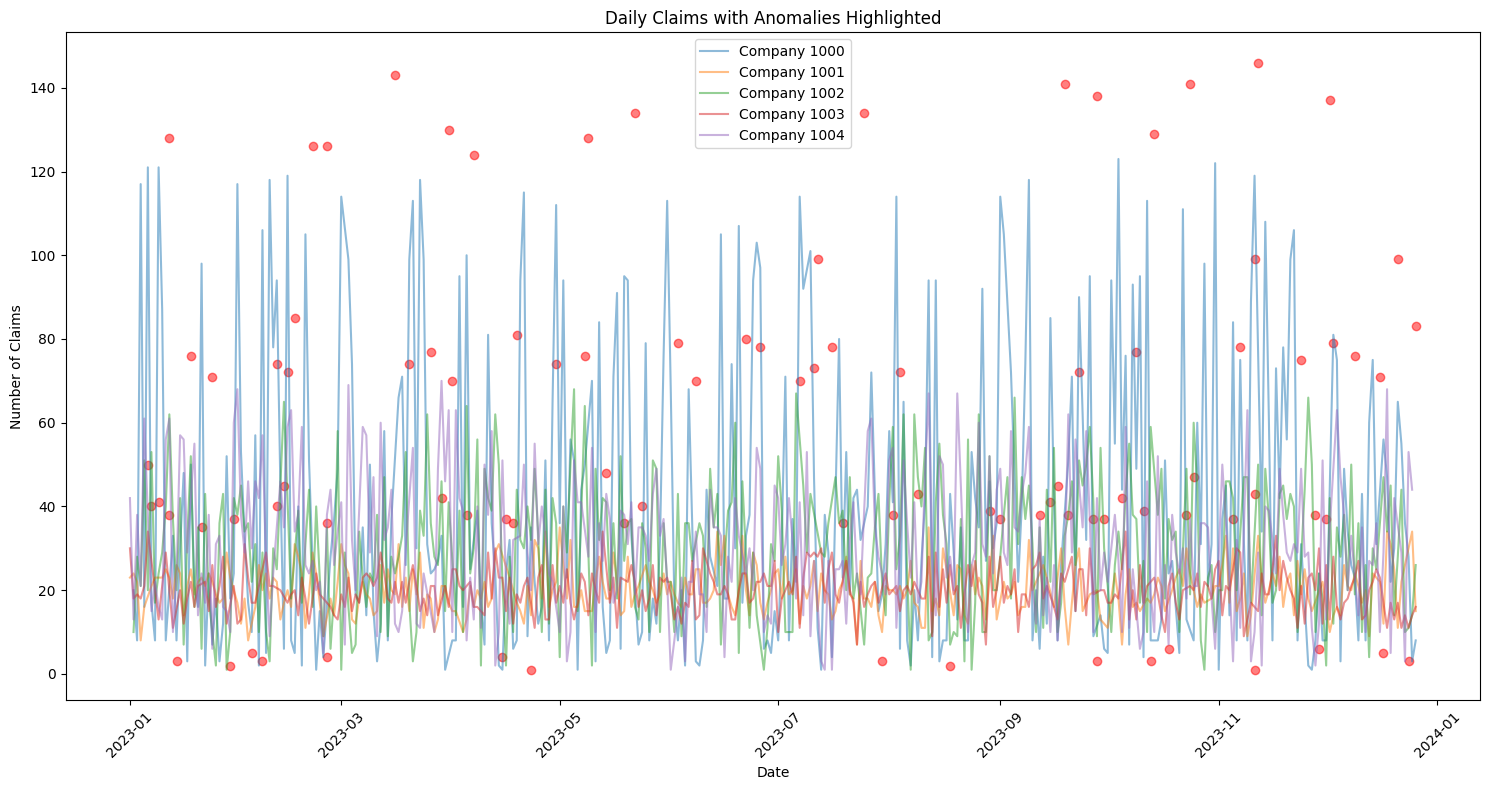

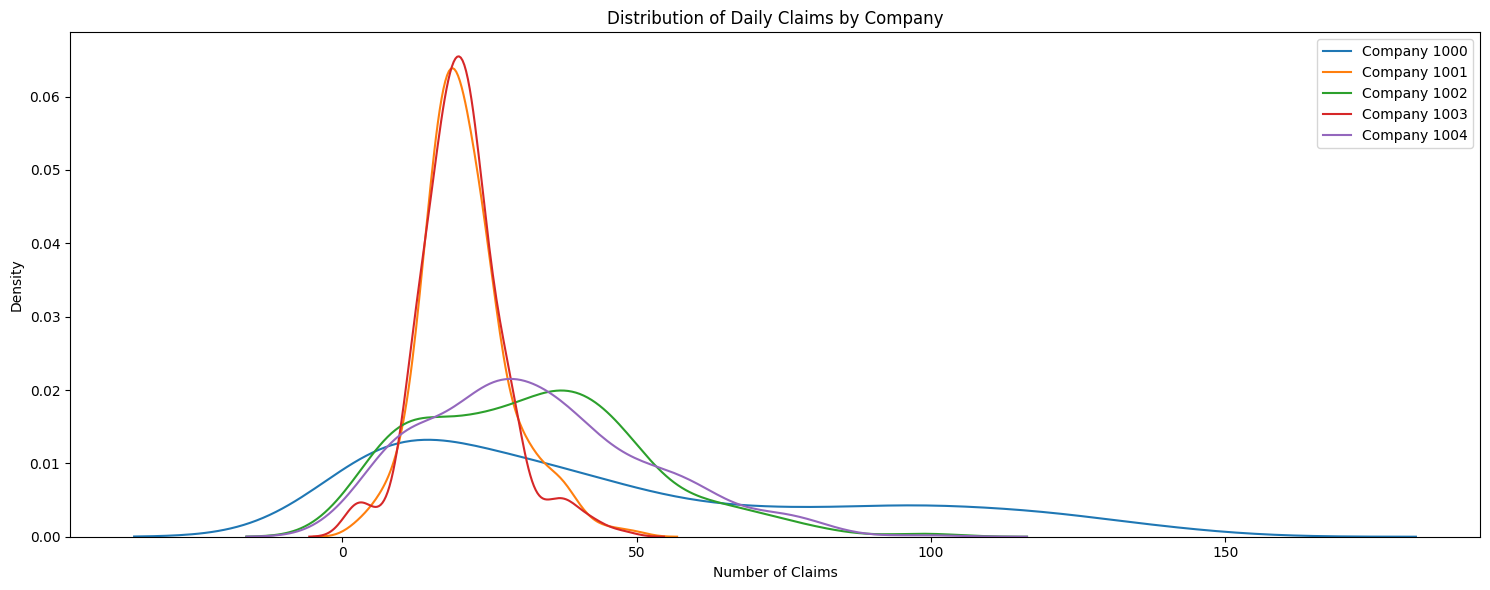

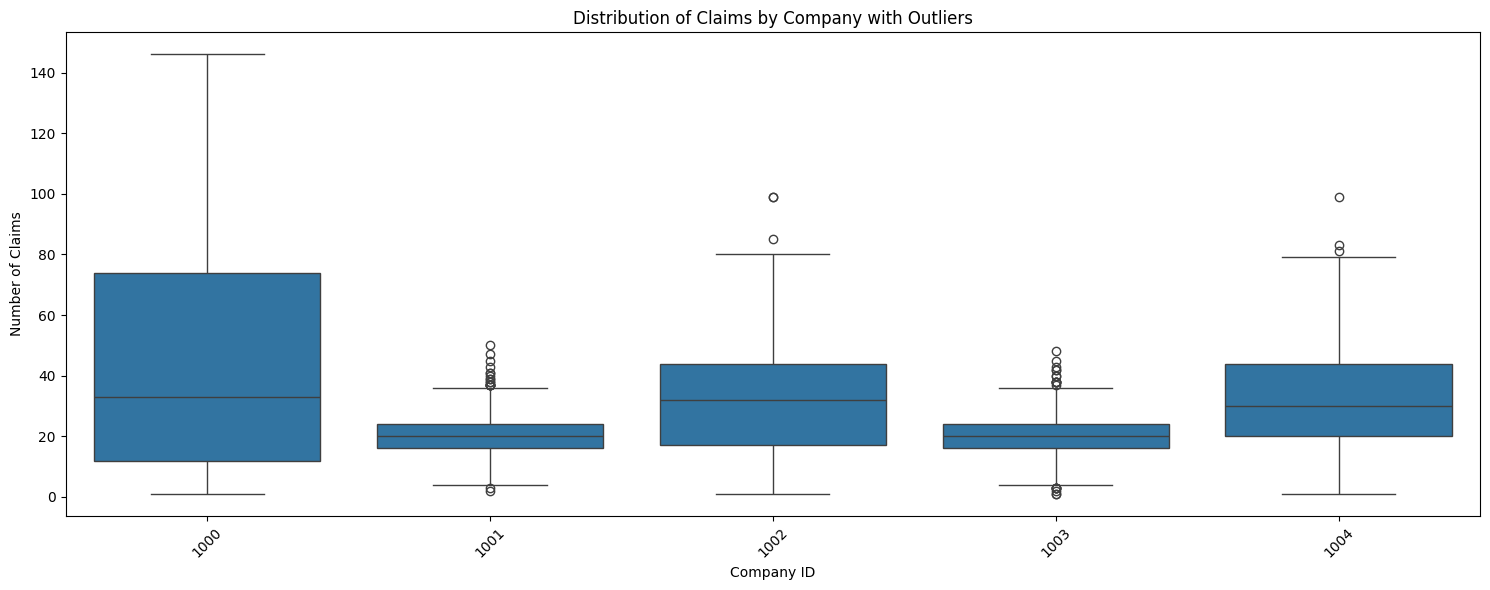

In [26]:
# Call the visualization function
visualize_claiming_patterns(daily_claims=daily_claims)

# Custom Modeling

## Initialize Model

In [51]:
# Run all methods
detector = ComprehensiveAnomalyDetector(daily_claims)

Using device: cpu


## Train Isolation Forest

In [57]:
iso_predictions, iso_model = detector.train_isolation_forest()
detector.iso_forest = iso_model  # Store for saving later


Training Isolation Forest...



## Train Autoencoder


In [58]:
auto_anomalies, auto_model, reconstruction_error, auto_losses = detector.train_autoencoder()
detector.auto_model = auto_model  # Store for saving later


Training Autoencoder...
Epoch [10/50], Loss: 0.5904
Epoch [20/50], Loss: 0.5816
Epoch [30/50], Loss: 0.5763
Epoch [40/50], Loss: 0.5734
Epoch [50/50], Loss: 0.5712



## Train Random Forest


In [59]:
rf_model, rf_eval, rf_importance = detector.train_random_forest()
detector.rf_model = rf_model  # Store for saving later


Training Random Forest...



## Train PyTorch supervised model


In [55]:
sup_model, (train_losses, test_losses), (predictions, actual) = detector.train_supervised_model()
detector.sup_model = sup_model  # Store for saving later


Training Supervised Model...
Epoch [10/50]
Train Loss: 0.1092, Test Loss: 0.0847
Epoch [20/50]
Train Loss: 0.0823, Test Loss: 0.0637
Epoch [30/50]
Train Loss: 0.0762, Test Loss: 0.0594
Epoch [40/50]
Train Loss: 0.0689, Test Loss: 0.0547
Epoch [50/50]
Train Loss: 0.0651, Test Loss: 0.0558


## Visualize results


Dataset Overview:
Total Records: 17,899
Labeled Anomalies: 1,132 (6.32%)

Model Detection Summary:

Isolation Forest Performance:
True Positives: 262 | False Positives: 633
False Negatives: 870 | True Negatives: 16,134
Precision: 29.27% | Recall: 23.14%

Autoencoder Performance:
True Positives: 180 | False Positives: 715
False Negatives: 952 | True Negatives: 16,052
Precision: 20.11% | Recall: 15.90%

Random Forest (Test Set) Performance:
True Positives: 199 | False Positives: 86
False Negatives: 23 | True Negatives: 3,272
Precision: 69.82% | Recall: 89.64%

Neural Network (Test Set) Performance:
True Positives: 160 | False Positives: 27
False Negatives: 62 | True Negatives: 3,331
Precision: 85.56% | Recall: 72.07%


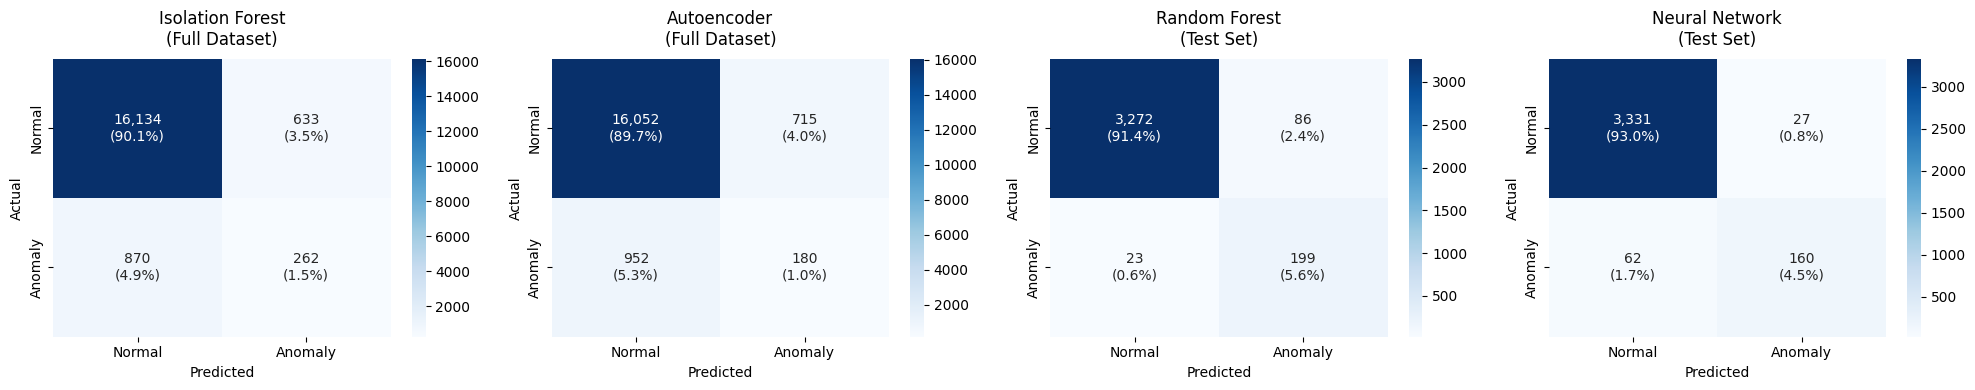

In [105]:
results = (
    iso_predictions, 
    auto_anomalies, 
    (rf_model, rf_eval, rf_importance),
    (sup_model, (train_losses, test_losses), (predictions, actual))
)
# Example usage:
viz = SimpleResults(detector, results)

# Get overall performance summary
viz.model_performance_summary()
viz.plot_confusion_matrices()

## Random Forest Results


In [106]:
print("\nRandom Forest Performance:")
print(classification_report(rf_eval[1], rf_eval[2]))


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3358
           1       0.70      0.90      0.79       222

    accuracy                           0.97      3580
   macro avg       0.85      0.94      0.88      3580
weighted avg       0.97      0.97      0.97      3580



## Pytorch Results

In [107]:
print("\nPyTorch Supervised Model Performance:")
print(classification_report(actual, predictions))


PyTorch Supervised Model Performance:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      3358
         1.0       0.86      0.72      0.78       222

    accuracy                           0.98      3580
   macro avg       0.92      0.86      0.88      3580
weighted avg       0.97      0.98      0.97      3580



# Feature Store Addition

In [ ]:
from dataclasses import dataclass
from enum import Enum
import pandas as pd
import numpy as np
from typing import List, Dict, Optional, Union

class CreationMode(Enum):
    CREATE = "CREATE"
    CREATE_IF_NOT_EXIST = "CREATE_IF_NOT_EXIST"
    FAIL_IF_EXISTS = "FAIL_IF_EXISTS"

@dataclass
class Entity:
    """Entity definition following Snowflake pattern"""
    name: str
    join_keys: List[str]
    desc: Optional[str] = None

@dataclass
class FeatureView:
    """FeatureView definition following Snowflake pattern"""
    name: str
    entities: List[Entity]
    feature_df: pd.DataFrame
    timestamp_col: str
    desc: Optional[str] = None

class FeatureStore:
    def __init__(
        self,
        database: str,
        name: str,
        creation_mode: CreationMode = CreationMode.CREATE_IF_NOT_EXIST
    ):
        """Initialize feature store similar to Snowflake's pattern"""
        self.database = database
        self.name = name
        self.creation_mode = creation_mode
        self.entities = {}
        self.feature_views = {}
        
    def register_entity(self, entity: Entity) -> Entity:
        """Register entity following Snowflake pattern"""
        if entity.name in self.entities and self.creation_mode == CreationMode.FAIL_IF_EXISTS:
            raise ValueError(f"Entity {entity.name} already exists")
            
        self.entities[entity.name] = entity
        return entity
    
    def register_feature_view(
        self, 
        feature_view: FeatureView, 
        version: str = "1", 
        overwrite: bool = False
    ) -> FeatureView:
        """Register feature view following Snowflake pattern"""
        key = f"{feature_view.name}_v{version}"
        if key in self.feature_views and not overwrite:
            raise ValueError(f"Feature view {key} already exists")
            
        self.feature_views[key] = feature_view
        return feature_view
    
    def list_entities(self) -> pd.DataFrame:
        """List registered entities in DataFrame format"""
        entities_list = []
        for name, entity in self.entities.items():
            entities_list.append({
                "NAME": name.upper(),
                "JOIN_KEYS": [",".join(entity.join_keys)],
                "DESC": entity.desc,
                "OWNER": "SYSTEM"
            })
        return pd.DataFrame(entities_list)
    
    def list_feature_views(self) -> pd.DataFrame:
        """List registered feature views in DataFrame format"""
        views_list = []
        for key, view in self.feature_views.items():
            name, version = key.split("_v")
            views_list.append({
                "NAME": name.upper(),
                "VERSION": version,
                "DATABASE_NAME": self.database,
                "SCHEMA_NAME": self.name,
                "CREATED_ON": pd.Timestamp.now(),
                "OWNER": "SYSTEM",
                "DESC": view.desc,
                "ENTITIES": [e.name for e in view.entities],
                "REFRESH_FREQ": None,
                "REFRESH_MODE": None,
                "SCHEDULING_STATE": None,
                "WAREHOUSE": None
            })
        return pd.DataFrame(views_list)
    
    def generate_dataset(
        self,
        name: str,
        spine_df: pd.DataFrame,
        features: List[FeatureView],
        spine_timestamp_col: str,
        spine_label_cols: Optional[List[str]] = None,
        include_feature_view_timestamp_col: bool = False
    ) -> pd.DataFrame:
        """Generate dataset following Snowflake pattern"""
        dataset = spine_df.copy()
        
        for feature_view in features:
            # Get the latest version of the feature view
            feature_df = feature_view.feature_df
            
            # Perform point-in-time correct join
            join_conditions = []
            for entity in feature_view.entities:
                for key in entity.join_keys:
                    join_conditions.append(f"dataset['{key}'] == feature_df['{key}']")
                    
            # Add timestamp condition
            join_conditions.append(
                f"feature_df['{feature_view.timestamp_col}'] <= dataset['{spine_timestamp_col}']"
            )
            
            # Create the join condition
            join_mask = eval(" & ".join(join_conditions))
            
            # Get the latest features for each entity before the spine timestamp
            latest_features = (
                feature_df[join_mask]
                .sort_values(feature_view.timestamp_col)
                .groupby(entity.join_keys)
                .last()
                .reset_index()
            )
            
            # Drop timestamp column if not requested
            if not include_feature_view_timestamp_col:
                latest_features = latest_features.drop(columns=[feature_view.timestamp_col])
                
            # Merge with dataset
            merge_keys = []
            for entity in feature_view.entities:
                merge_keys.extend(entity.join_keys)
            dataset = dataset.merge(latest_features, on=merge_keys, how='left')
            
        return dataset


In [ ]:
from snowflake.ml.feature_store import FeatureStore, CreationMode, Entity, FeatureView
from snowflake.snowpark.context import get_active_session
from snowflake.snowpark import Session, Window
from snowflake.snowpark import functions as F


session = get_active_session()
fs = FeatureStore(
    session=session,
    database="DATASCIENCE",
    name="CLAIMS_FEATURES",
    default_warehouse='ds_wh_xs',
    creation_mode=CreationMode.CREATE_IF_NOT_EXIST,
)

# Register company entity
entity = Entity(
    name="company",
    join_keys=["COMPANY_ID"],
    desc="Company identifier for claims analysis"
    creation_mode=CreationMode.CREATE_IF_NOT_EXIST,
)
fs.register_entity(entity)
fs.list_entities().show()

df = session.table('datascience.enlyte.claims')
df.show()


# Create daily claims aggregation
daily_claims = df.group_by(
    'COMPANY_ID',
    F.col('BILL_CREATE_DATE')
).agg(
    F.count('CLAIM_ID_NO').alias('CLAIM_COUNT'),
    F.sum('PROVIDER_CHARGES').alias('TOTAL_CHARGES')
).select(
    'COMPANY_ID',
    F.col('BILL_CREATE_DATE').alias('DATE'),
    'CLAIM_COUNT',
    'TOTAL_CHARGES'
)

# Create window specification for company-level statistics
company_window = Window.partition_by('COMPANY_ID')

# Calculate company-level statistics using window functions
daily_claims = daily_claims.select(
    '*',  # Keep all existing columns
    F.mean('CLAIM_COUNT').over(company_window).alias('mean_claims'),
    F.stddev('CLAIM_COUNT').over(company_window).alias('std_claims'),
    F.min('CLAIM_COUNT').over(company_window).alias('min_claims'),
    F.max('CLAIM_COUNT').over(company_window).alias('max_claims')
)

# Calculate thresholds
daily_claims = daily_claims.select(
    '*',  # Keep all existing columns
    (F.col('mean_claims') + (2 * F.col('std_claims'))).alias('threshold_high'),
    F.greatest(F.lit(0), F.col('mean_claims') - (2 * F.col('std_claims'))).alias('threshold_low')
)

# Identify anomalies
daily_claims = daily_claims.with_column(
    'is_anomaly',
    (F.col('CLAIM_COUNT') > F.col('threshold_high')) |
    (F.col('CLAIM_COUNT') < F.col('threshold_low'))
)

daily_claims.select(
    F.col("COMPANY_ID"),
    F.col("DATE"),
    F.col("CLAIM_COUNT"),
    F.col("TOTAL_CHARGES")
).analytics.time_series_agg(
    time_col="DATE",
    group_by=entity.join_keys,  # ["COMPANY_ID"]
    aggs={
        "CLAIM_COUNT": ["AVG", "SUM"],
        "TOTAL_CHARGES": ["AVG", "SUM"]
    },
    windows=["-1D", "-7D", "-30D", "-90D"],
    sliding_interval="1D",
    col_formatter=lambda input_col, agg, window: f"{input_col}_{agg}_{window.lstrip('-')}"
).drop(F.col("SLIDING_POINT"))

feature_view = FeatureView(
    name="claims_patterns",
    entities=[entity],
    feature_df=daily_claims,
    timestamp_col="DATE",
    desc="Enhanced claims patterns including temporal features and anomaly indicators"
)
claim_view = fs.register_feature_view(feature_view, version="1", overwrite=True)
fs.list_feature_views().to_pandas()

In [ ]:


# Example usage:
def demonstrate_feature_store():
    # Create feature store
    fs = create_anomaly_feature_store(daily_claims)
    
    # Show registered entities
    print("Registered Entities:")
    print(fs.list_entities())
    print("\nRegistered Feature Views:")
    print(fs.list_feature_views())
    
    # Generate training dataset
    spine_df = daily_claims[['DATE', 'COMPANY_ID', 'CLAIM_COUNT', 'is_anomaly']].copy()
    
    ds = fs.generate_dataset(
        name="anomaly_training",
        spine_df=spine_df,
        features=[fs.feature_views['claims_history_v1']],
        spine_timestamp_col="DATE",
        spine_label_cols=["is_anomaly"]
    )
    
    print("\nGenerated Dataset Preview:")
    print(ds.head())
    
    return fs, ds

# Run demonstration
fs, training_dataset = demonstrate_feature_store()